# Interconnect DS Project

# Project Description

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

# **Plan**

1.   [Data Preprocessing](#Data-Preprocessing)
  *   Look at the data
  *   Change data types
  *   Join the tables
  *   Make decition about NaN values
2.   [EDA](#EDA)
  *  Figure out what data is more relevant for prediction task and what is the target value
  *  Try to find some pattern or new info that can be used
3.   [Models training](#Model-Training)
  *  Use cross-validation for better traning
  *  Hyperparameter tuning
  *  Choose the best model rest on the choosen metric (AUC-ROC)
4.   [Test the model](#Test-the-model)
5. [Conclusion](#Solution-Report) 


In [ ]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#collapse_output
!pip3 install catboost

     |████████████████████████████████| 65.7MB 71kB/s 


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, cv, Dataset
from catboost import Pool, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor

# **Data Preprocessing**

In [ ]:
#hide
path_to_contract =  '/content/drive/My Drive/final_project_data/final_provider/contract.csv'
path_to_internet =  '/content/drive/My Drive/final_project_data/final_provider/internet.csv'
path_to_personal =  '/content/drive/My Drive/final_project_data/final_provider/personal.csv'
path_to_phone =  '/content/drive/My Drive/final_project_data/final_provider/phone.csv'

In [ ]:
contract =  pd.read_csv(path_to_contract)
internet =  pd.read_csv(path_to_internet)
personal =  pd.read_csv(path_to_personal)
phone =  pd.read_csv(path_to_phone)

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
#collapse_output
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
#collapse_output
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
#collapse_output
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
#collapse_output
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
internet['FiberOptic'] = (internet['InternetService'] == 'Fiber optic').astype(int)
internet = internet.drop(columns=['InternetService'])

In [ ]:
df = contract.merge(phone, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(personal, on='customerID', how='left')

In [ ]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,FiberOptic,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,No,Yes,No,No,No,No,0.0,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,Yes,No,Yes,No,No,No,0.0,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,Yes,Yes,No,No,No,No,0.0,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,Yes,No,Yes,Yes,No,No,0.0,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,No,No,No,No,No,No,1.0,Female,0,No,No


In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')
df['TotalCharges'] = df['TotalCharges'].round(2)

In [ ]:
columns = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
           'StreamingMovies', 'FiberOptic', 'SeniorCitizen', 'PaperlessBilling', 'Partner',	'Dependents', 'TotalCharges','MonthlyCharges']
for i in columns:
  df[i] = df[i].replace('No', 0)
  df[i] = df[i].replace('Yes', 1)
  df[i] =  df[i].fillna(0)
  df[i] = df[i].astype(int)

In [ ]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')

In [ ]:
df['Woman'] = (df['gender'] == 'Female').astype(int)
df = df.drop(columns=['gender'])

Need to explore ex-users and find something common between them. 

For client who didn't exist in phone or internet tables NaN values should be fiiled with False value or 0 in the case. Probably they didn't use those services. 

# **EDA**

In [ ]:
df['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [ ]:
current_users = df.loc[df['EndDate'] == 'No']

In [ ]:
ex_users = df.loc[df['EndDate'] != 'No']

In [ ]:
ex_users['BeginDate'] = ex_users['BeginDate'].dt.year
current_users['BeginDate'] = current_users['BeginDate'].dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


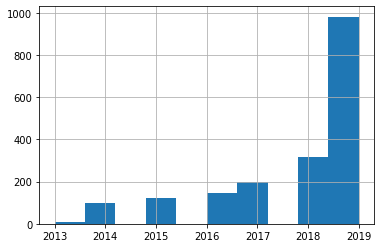

In [ ]:
ex_users['BeginDate'].hist()

There are a lot of new users from 2019 year who probably decided to try, but the service didn't sute them for some reason.

In [ ]:
arg_difference = {'Ex-Users': ex_users.mean(), 'Current-Users': current_users.mean()}
arg_difference_df = pd.DataFrame(data=arg_difference)

In [ ]:
arg_difference_df

,Ex-Users,Current-Users
BeginDate,2017.834671,2016.533243
PaperlessBilling,0.749064,0.535562
MonthlyCharges,73.979668,60.797835
TotalCharges,1531.323167,2549.443564
MultipleLines,0.454789,0.409934
OnlineSecurity,0.157838,0.333204
OnlineBackup,0.279829,0.368380
DeviceProtection,0.291600,0.362775
TechSupport,0.165864,0.335137
StreamingTV,0.435527,0.365868


In [ ]:
ex_users.groupby('BeginDate').mean()

,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,FiberOptic,SeniorCitizen,Partner,Dependents,Woman
BeginDate,,,,,,,,,,,,,,,
2013,0.750000,100.125000,7137.750000,1.000000,0.625000,0.625000,0.875000,0.750000,0.875000,0.875000,0.750000,0.250000,0.875000,0.250000,0.500000
2014,0.775510,95.724490,6316.387755,0.826531,0.326531,0.734694,0.663265,0.387755,0.836735,0.846939,0.846939,0.255102,0.724490,0.295918,0.367347
2015,0.756098,88.000000,4646.040650,0.747967,0.325203,0.560976,0.512195,0.243902,0.731707,0.699187,0.796748,0.308943,0.601626,0.203252,0.471545
2016,0.813793,83.882759,3441.834483,0.600000,0.262069,0.475862,0.510345,0.317241,0.613793,0.627586,0.744828,0.365517,0.482759,0.172414,0.503448
2017,0.804020,82.884422,2375.693467,0.643216,0.190955,0.381910,0.361809,0.185930,0.537688,0.562814,0.824121,0.331658,0.492462,0.236181,0.532663
2018,0.790476,78.352381,1254.796825,0.517460,0.187302,0.269841,0.314286,0.190476,0.498413,0.501587,0.752381,0.279365,0.387302,0.184127,0.517460
2019,0.711519,65.162080,252.173293,0.296636,0.084608,0.149847,0.168196,0.094801,0.287462,0.286442,0.612640,0.207951,0.231397,0.142712,0.508665


In [ ]:
current_users.groupby('BeginDate').mean()

,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,FiberOptic,SeniorCitizen,Partner,Dependents,Woman
BeginDate,,,,,,,,,,,,,,,
2014,0.581059,74.090690,5121.858748,0.662921,0.542536,0.605939,0.600321,0.539326,0.561798,0.570626,0.418941,0.155698,0.763242,0.413323,0.483949
2015,0.578875,67.499314,3785.851852,0.508916,0.393690,0.462277,0.452675,0.406036,0.462277,0.475995,0.407407,0.153635,0.639232,0.370370,0.511660
2016,0.550162,62.250809,2746.218447,0.428803,0.330097,0.385113,0.399676,0.317152,0.401294,0.401294,0.364078,0.119741,0.548544,0.360841,0.525890
2017,0.518576,60.730650,1913.739938,0.380805,0.297214,0.329721,0.349845,0.326625,0.349845,0.345201,0.362229,0.147059,0.487616,0.329721,0.470588
2018,0.511888,54.158042,1074.416783,0.309091,0.236364,0.236364,0.236364,0.237762,0.261538,0.254545,0.318881,0.114685,0.446154,0.335664,0.492308
2019,0.498975,48.607582,347.054303,0.175205,0.177254,0.178279,0.148566,0.170082,0.184426,0.191598,0.267418,0.099385,0.309426,0.272541,0.501025
2020,0.397541,37.610656,35.766393,0.086066,0.094262,0.081967,0.049180,0.094262,0.061475,0.065574,0.131148,0.049180,0.168033,0.233607,0.422131


### **Conclution of EDA:**

Our ex-clients usually had internet with Fiber Optic, used Streaming TV and Streaming Movies and as an obvious fact paid more.
They also less used Tech Support, more of them used Multiple Lines of the phone and there are more SeniorCitizen among ex-users. 

Partner and Gender information don't seem to be relevant, but Dependents can be as there are some difference by this parameter. 

Most of the ex-users came to us in 2019 year.


### **Questions:**


1.   What do Partner and Dependents columns mean? Are they relevant? 
2.   What the most relevant columns would be the best to take as the features for machine leaning model?
3.   What is the target value?
4.   It is a classification task: whether or not the user will quit, isn't it?
5.   What metric to use?


Our target column is EndDate. As far as it should has boolean type (with us or not), so the column values should be changed.

It's better to remain all features as all of them can be relevant to the customer decision to leave or to stay. 

It is a classification task, but Logistic regression can be used as there are only two target options.

AUC-ROC metric should be used here to find the best model, because our data is unballanced and it needs to take in account the rate of false-positive and false-negative values.

# **Model Training**

## Creating Features

In [ ]:
df['IsClient'] = (df['EndDate'] == 'No').astype(int)

In [ ]:
df['EndDate'] = df['EndDate'].where(df['EndDate'] != 'No', "2020-02-01")
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

In [ ]:
df["AllTime"] = (df['EndDate'] - df['BeginDate']) 
df["AllTime"] = (df["AllTime"] / np.timedelta64(1, "M"))
df["AllTime"] = df["AllTime"].astype(int)

In [ ]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,FiberOptic,SeniorCitizen,Partner,Dependents,Woman,IsClient,AllTime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29,29,0,0,1,0,0,0,0,0,0,1,0,1,1,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56,1889,0,1,0,1,0,0,0,0,0,0,0,0,1,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53,108,0,1,1,0,0,0,0,0,0,0,0,0,0,2
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42,1840,0,1,0,1,1,0,0,0,0,0,0,0,1,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70,151,0,0,0,0,0,0,0,1,0,0,0,1,0,2


In [ ]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'FiberOptic', 'SeniorCitizen',
       'Partner', 'Dependents', 'Woman', 'IsClient', 'AllTime'],
      dtype='object')

In [ ]:
X = df.drop(['customerID', 'BeginDate', 'EndDate','Partner', 'Woman', 'IsClient'], axis=1)
y = df['IsClient']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Type              7043 non-null   object
 1   PaperlessBilling  7043 non-null   int64 
 2   PaymentMethod     7043 non-null   object
 3   MonthlyCharges    7043 non-null   int64 
 4   TotalCharges      7043 non-null   int64 
 5   MultipleLines     7043 non-null   int64 
 6   OnlineSecurity    7043 non-null   int64 
 7   OnlineBackup      7043 non-null   int64 
 8   DeviceProtection  7043 non-null   int64 
 9   TechSupport       7043 non-null   int64 
 10  StreamingTV       7043 non-null   int64 
 11  StreamingMovies   7043 non-null   int64 
 12  FiberOptic        7043 non-null   int64 
 13  SeniorCitizen     7043 non-null   int64 
 14  Dependents        7043 non-null   int64 
 15  AllTime           7043 non-null   int64 
dtypes: int64(14), object(2)
memory usage: 935.4+ KB


In [ ]:
encoder = OrdinalEncoder()
X = pd.DataFrame(encoder.fit_transform(X), columns = X.columns)

In [ ]:
X.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,FiberOptic,SeniorCitizen,Dependents,AllTime
0,0.0,1.0,2.0,10.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,3.0,36.0,1539.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0
2,0.0,1.0,3.0,33.0,89.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,1.0,0.0,0.0,22.0,1503.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,45.0
4,0.0,1.0,2.0,50.0,131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0


In [ ]:
for i in X.columns:
  X[i] = X[i].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [ ]:
X.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,FiberOptic,SeniorCitizen,Dependents,AllTime
0,0,1,2,10,10,0,0,1,0,0,0,0,0,0,0,1
1,1,0,3,36,1539,0,1,0,1,0,0,0,0,0,0,34
2,0,1,3,33,89,0,1,1,0,0,0,0,0,0,0,2
3,1,0,0,22,1503,0,1,0,1,1,0,0,0,0,0,45
4,0,1,2,50,131,0,0,0,0,0,0,0,1,0,0,2


## Dummy model

In [ ]:
scorer_for_cv = make_scorer(roc_auc_score) 

In [ ]:
dummy_regr = DummyRegressor(strategy="constant", constant=0)
dummy_regr.fit(X_train, y_train)
dummy_predict = dummy_regr.predict(X_test)

In [ ]:
dummy_auc = roc_auc_score(y_test, dummy_predict)
print("AUC-ROC =", dummy_auc)

AUC-ROC = 0.5


## Linear regression

In [ ]:
model_lr = LinearRegression()

param_grid = [{'normalize': [True, False]}]
model_lr_cv = GridSearchCV(estimator=model_lr,
                           scoring=scorer_for_cv,
                           param_grid=param_grid,
                           cv=3)
model_lr_cv = model_lr_cv.fit(X_train, y_train)

In [ ]:
model_lr_cv.best_score_

0.9134962791064755

## Random forrest

In [ ]:
model_rfr = RandomForestRegressor()

param_grid = [
   {'n_estimators':[20], 'max_depth':[12], 'random_state':[12345]},
  {'n_estimators':[50], 'max_depth':[5],'random_state':[12345]},
  {'n_estimators':[50],'max_depth':[50], 'random_state':[12345]}]


model_rfr_cv = GridSearchCV(estimator=model_rfr,
                          param_grid=param_grid,
                           scoring=scorer_for_cv,
                          cv=5)
model_rfr_cv = model_rfr_cv.fit(X_train, y_train)

In [ ]:
model_rfr_cv.best_score_

0.9228055321689848

## Gradient boosting

In [ ]:
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=['PaperlessBilling',  'TotalCharges', 'MultipleLines', 'MonthlyCharges','AllTime', 
                  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                  'StreamingTV', 'StreamingMovies', 'FiberOptic', 'SeniorCitizen',
                    'Dependents']) 
model_CatBoostRegressor = CatBoostRegressor(eval_metric='AUC')

In [ ]:
#collapse_output
param_grid = [
  {'iterations': [5, 10, 100], 'depth':[5, 10, 15], 'learning_rate':[1]}]

model_cb_cv = model_CatBoostRegressor.grid_search(param_grid, 
                                                   X=train_pool,
                                                   cv=3)


bestTest = 0.8371061337
bestIteration = 4

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8371061	best: 0.8371061 (0)	total: 76.8ms	remaining: 615ms

bestTest = 0.8401220378
bestIteration = 6

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8401220	best: 0.8401220 (1)	total: 102ms	remaining: 358ms

bestTest = 0.8451820289
bestIteration = 14

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8451820	best: 0.8451820 (2)	total: 316ms	remaining: 633ms

bestTest = 0.826336716
bestIteration = 3

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8263367	best: 0.8451820 (2)	total: 374ms	remaining: 468ms

bestTest =

In [ ]:
print("The best parameters is", model_cb_cv['params'])

The best parameters is {'depth': 5, 'learning_rate': 1, 'iterations': 100}


In [ ]:
#collapse_output
model_cb_cv = CatBoostRegressor(iterations=100, depth=5, 
                                        learning_rate=1, eval_metric='AUC')
model_cb_cv.fit(train_pool)

0:	total: 3.66ms	remaining: 363ms
1:	total: 6ms	remaining: 294ms
2:	total: 8.94ms	remaining: 289ms
3:	total: 11.6ms	remaining: 279ms
4:	total: 13.9ms	remaining: 264ms
5:	total: 16.3ms	remaining: 255ms
6:	total: 18.7ms	remaining: 248ms
7:	total: 21ms	remaining: 242ms
8:	total: 23.4ms	remaining: 237ms
9:	total: 25.7ms	remaining: 231ms
10:	total: 28.1ms	remaining: 227ms
11:	total: 30.4ms	remaining: 223ms
12:	total: 32.7ms	remaining: 219ms
13:	total: 34.9ms	remaining: 215ms
14:	total: 37.2ms	remaining: 211ms
15:	total: 39.4ms	remaining: 207ms
16:	total: 41.6ms	remaining: 203ms
17:	total: 44.2ms	remaining: 201ms
18:	total: 46.5ms	remaining: 198ms
19:	total: 48.7ms	remaining: 195ms
20:	total: 51ms	remaining: 192ms
21:	total: 53.3ms	remaining: 189ms
22:	total: 55.6ms	remaining: 186ms
23:	total: 57.9ms	remaining: 183ms
24:	total: 60.6ms	remaining: 182ms
25:	total: 63ms	remaining: 179ms
26:	total: 65.5ms	remaining: 177ms
27:	total: 67.9ms	remaining: 175ms
28:	total: 70.3ms	remaining: 172ms
29:	

# **Test the model**

### **Linear regression**

In [ ]:
y_pred = model_lr_cv.predict(X_test)
lr_auc = roc_auc_score(y_test, y_pred)
print("AUC-ROC =", lr_auc)

AUC-ROC = 0.8293950540785984


### **Random forrest**

In [ ]:
y_pred = model_rfr_cv.predict(X_test)
rfr_auc = roc_auc_score(y_test, y_pred)
print("AUC-ROC =", rfr_auc)

AUC-ROC = 0.8531534101154354


### **CatBoostClassifier**

In [ ]:
test_pool = Pool(X_test, 
                  cat_features=['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'FiberOptic', 'SeniorCitizen',
        'Dependents', 'AllTime']) 
y_pred = model_cb_cv.predict(test_pool)
print(y_pred)

cbc_auc = roc_auc_score(y_test, y_pred)
print("AUC-ROC =", cbc_auc)

[0.88648241 0.46205313 0.10287211 ... 0.79784994 1.16184092 1.02592976]
AUC-ROC = 0.8272001088456784


# **Solution Report**

* Question: What steps of the plan were performed and what steps were skipped (explain why)? 
* Answer: It was no need to skip any steps in the plan, so all steps were performed. 


---

* Question: What difficulties did you encounter and how did you manage to solve them?
* Answer: The difficult and unsucceded part was to increase the AUC-ROC metric more than 0.88. 



---



* Question: What were some of the key steps to solving the task?
* Answer: The key steps were to prepare data for model training and to find the best hyperparameters. 


---


* Question: What is your final model and what quality score does it have?
* Answer: The Random Forest model gave the best result - it's AUC-ROC metric has value 0,853. It is the best model to predict the churn of clients. 